In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm
from scipy import stats
from fastai.tabular import * 

In [2]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *
import numpy as np 
import pandas as pd 
from pathlib import Path 
import os


In [6]:
train=pd.read_csv('Train_aBjfeNk.csv')
test=pd.read_csv('Test_LqhgPWU.csv')

In [7]:
train.head(10)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


In [8]:
train.isna().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

**EDA**

##### Find % Missing Values in train and test

In [11]:
missing_vals_train = train.isnull().sum() / train.shape[0]
missing_vals_train[missing_vals_train > 0].sort_values(ascending=False)

Work_Experience    0.102752
Family_Size        0.041522
Ever_Married       0.017353
Profession         0.015369
Graduated          0.009668
Var_1              0.009420
dtype: float64

In [12]:
missing_vals_test = test.isnull().sum() / test.shape[0]
missing_vals_test[missing_vals_test > 0].sort_values(ascending=False)

Work_Experience    0.102398
Family_Size        0.043015
Ever_Married       0.019033
Profession         0.014465
Var_1              0.012181
Graduated          0.009136
dtype: float64

Get Gender Distribution in the train and test data

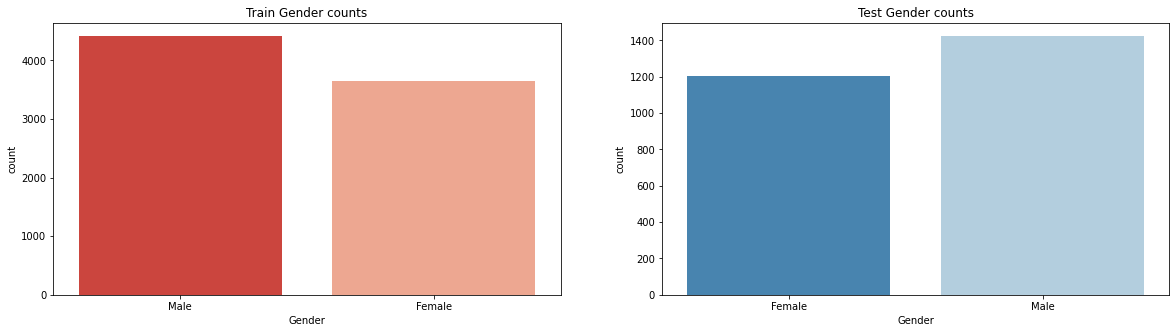

In [17]:
import seaborn as sns
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train.Gender, palette="Reds_r", ax=ax[0]);
ax[0].set_title("Train Gender counts");

sns.countplot(test.Gender, palette="Blues_r", ax=ax[1]);
ax[1].set_title("Test Gender counts");

##### Check unique record of customers in train and test

In [24]:
customer_counts_train = train.ID.nunique()
assert(customer_counts_train==train.shape[0])

customer_counts_test = test.ID.nunique()
assert(customer_counts_test==test.shape[0])


##### We can find that train and test doesnt have lot of unique ids.Test consist of lot of train ids but with varied inputs.</br> We can find that 88% of test ids are already present in the train set. Out of them 5% are exact matches.</br> From the remaining 83% 43% are matching on all the attributes except age and 5% are matching on except work experience.

In [36]:
test[test.ID.isin(train.ID.unique().tolist())].ID.count()/test.shape[0]

0.8877046060144652

##### Find exact matches in both dataset

In [47]:
pd.merge(train,test,how='inner', on=[
  'ID',
 'Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Var_1'                                 
]).shape[0]/test.shape[0]

0.05177007993909402

In [53]:
pd.merge(train,test,how='inner', on=[
  'ID',
 'Gender',
 'Ever_Married',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Var_1'                                 
]).shape[0]/test.shape[0]

0.4529881994670727

In [54]:
pd.merge(train,test,how='inner', on=[
  'ID',
 'Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Profession',
 'Spending_Score',
 'Family_Size',
 'Var_1'                                 
]).shape[0]/test.shape[0]

0.10392082223068139

In [41]:
test_cpd.merge(train,test,how='left', on='ID')

In [44]:
test_combine[
 (test_combine.Age_x==test_combine.Age_y)    
 &(test_combine.Age_x==test_combine.Age_y)      
]

,ID,Gender_x,Ever_Married_x,Age_x,Graduated_x,Profession_x,Work_Experience_x,Spending_Score_x,Family_Size_x,Var_1_x,Segmentation,Gender_y,Ever_Married_y,Age_y,Graduated_y,Profession_y,Work_Experience_y,Spending_Score_y,Family_Size_y,Var_1_y
29,461996,Female,No,35,No,Artist,5.0,Low,4.0,Cat_6,C,Female,No,35.0,No,Artist,7.0,Low,4.0,Cat_6
32,462454,Male,No,19,No,Healthcare,1.0,Low,3.0,Cat_2,D,Male,No,19.0,No,Healthcare,1.0,Low,3.0,Cat_2
35,467917,Female,No,27,Yes,Healthcare,3.0,Low,4.0,Cat_1,D,Female,No,27.0,Yes,Healthcare,2.0,Low,4.0,Cat_1
39,467442,Male,Yes,56,Yes,Artist,NaN,Average,2.0,Cat_6,C,Male,Yes,56.0,Yes,Artist,NaN,Average,2.0,Cat_6
56,465769,Male,No,25,Yes,Healthcare,9.0,Low,4.0,Cat_6,D,Male,No,25.0,Yes,Healthcare,8.0,Low,4.0,Cat_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7970,464739,Male,Yes,67,Yes,Artist,1.0,Low,1.0,Cat_4,B,Male,Yes,67.0,Yes,Artist,0.0,Low,1.0,Cat_4
8018,460935,Male,Yes,87,Yes,Lawyer,0.0,Low,1.0,Cat_6,D,Male,Yes,87.0,Yes,Lawyer,0.0,Low,1.0,Cat_6
8023,464274,Female,Yes,56,Yes,Artist,1.0,Average,5.0,Cat_6,C,Female,Yes,56.0,Yes,Artist,1.0,Average,5.0,Cat_6
8036,461612,Female,No,31,Yes,Healthcare,8.0,Low,5.0,Cat_6,C,Female,No,31.0,Yes,Healthcare,8.0,Low,5.0,Cat_6


In [26]:
test[test.ID.isin(train.ID.unique().tolist())]

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6
...,...,...,...,...,...,...,...,...,...,...
2620,467949,Male,No,21,No,Healthcare,1.0,Low,4.0,Cat_4
2621,467950,Female,No,35,Yes,Entertainment,1.0,Low,2.0,Cat_6
2622,467954,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6
2623,467958,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6


#### Get Age Distribution in train and test

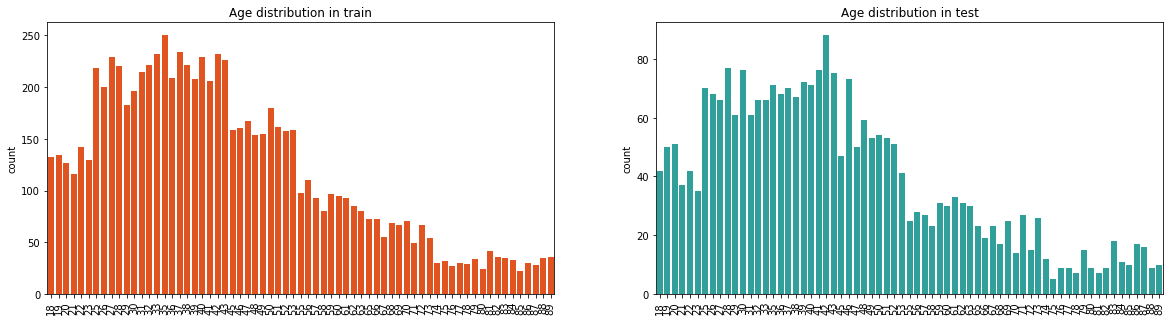

In [18]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.countplot(train.Age, color="orangered", ax=ax[0]);
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_xlabel("");
ax[0].set_title("Age distribution in train");

sns.countplot(test.Age, color="lightseagreen", ax=ax[1]);
labels = ax[1].get_xticklabels();
ax[1].set_xticklabels(labels, rotation=90);
ax[1].set_xlabel("");
ax[1].set_title("Age distribution in test");

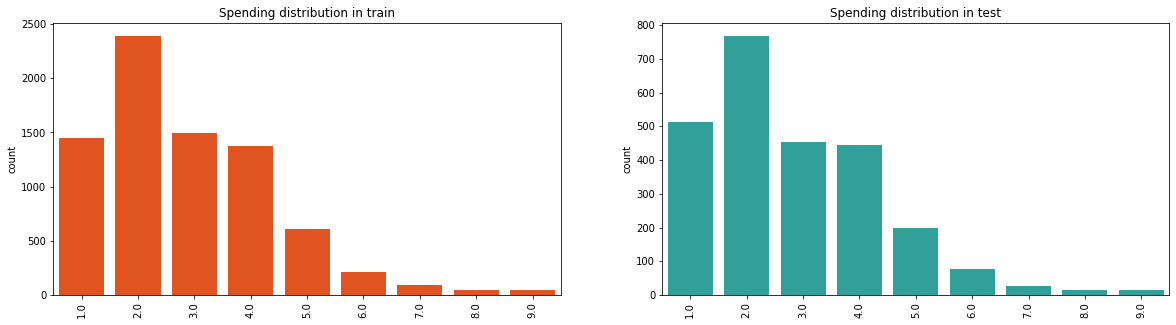

In [59]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.countplot(train.Family_Size, color="orangered", ax=ax[0]);
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_xlabel("");
ax[0].set_title("Spending distribution in train");

sns.countplot(test.Family_Size, color="lightseagreen", ax=ax[1]);
labels = ax[1].get_xticklabels();
ax[1].set_xticklabels(labels, rotation=90);
ax[1].set_xlabel("");
ax[1].set_title("Spending distribution in test");

In [57]:
train.columns.tolist()

['ID',
 'Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Var_1',
 'Segmentation']

In [61]:
procs = [FillMissing, Categorify, Normalize]
valid_idx = range(len(train)-200, len(train))
cont_names=['Age']
cat_names=['Ever_Married','Spending_Score','Profession','Graduated','Gender','Var_1','Work_Experience','Family_Size']
dep_var = 'Segmentation'
path=Path('.')
valid_idx

range(7868, 8068)

In [62]:
data = (TabularList.from_df(train, path=path,cat_names=cat_names,cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx)
                           .label_from_df(cols=dep_var, label_cls=CategoryList)
                           .add_test(TabularList.from_df(test, path=path,cat_names=cat_names,cont_names=cont_names,  procs=procs))
                           .databunch())

In [72]:
data.y.classes

['A', 'B', 'C', 'D']

In [64]:
np.random.seed(1234)
learn = tabular_learner(data, layers=[500,250,100],
                        emb_drop= 0.04,
                        ps=[0.05,0.01,0.01],
                        callback_fns=ShowGraph,metrics=accuracy)


epoch,train_loss,valid_loss,accuracy,time
0,1.146298,1.079605,0.560000,00:03
1,1.072705,1.078757,0.545000,00:02


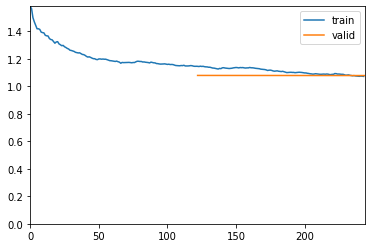

In [65]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.58E-05


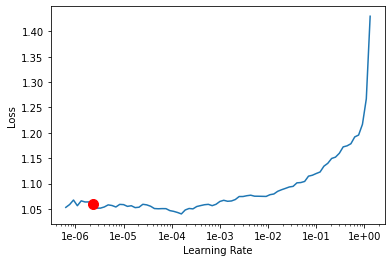

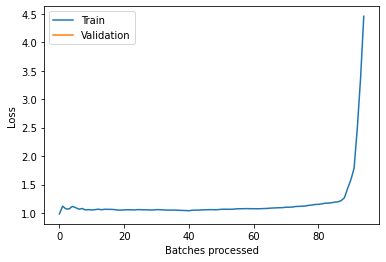

In [66]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
learn.model
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,1.064492,1.078276,0.535000,00:02
1,1.054135,1.073987,0.535000,00:02
2,1.047986,1.075144,0.530000,00:02
3,1.054602,1.073913,0.535000,00:02
4,1.048478,1.075132,0.530000,00:02


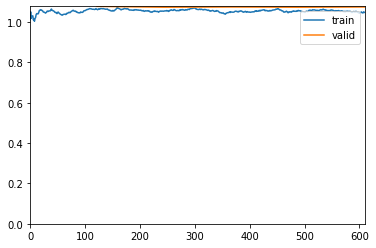

In [67]:
learn.fit_one_cycle(5, 2e-06, wd=0.2)

In [82]:
preds, y = learn.get_preds(ds_type=DatasetType.Test)
y

tensor([0, 0, 0,  ..., 0, 0, 0])

In [87]:

test['newpred'] = np.argmax(preds,1)
cat_map = {
    0:"A",
    1:"B",
    2:"C",
    3:"D"
}
test["newpredc"] = test['newpred'].map(cat_map)


In [ ]:
train[['ID','Segmentation']]

In [91]:
check_restults=pd.merge(test, train, how='left', on = 'ID')

In [98]:
check_restults[check_restults.Segmentation.isnull()]

,ID,Gender_x,Ever_Married_x,Age_x,Graduated_x,Profession_x,Work_Experience_x,Spending_Score_x,Family_Size_x,Var_1_x,newpred,newpredc,Gender_y,Ever_Married_y,Age_y,Graduated_y,Profession_y,Work_Experience_y,Spending_Score_y,Family_Size_y,Var_1_y,Segmentation
6,459005,Male,Yes,61,Yes,Doctor,5.0,Low,3.0,Cat_6,1,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,459045,Female,Yes,88,Yes,Lawyer,1.0,Average,4.0,Cat_6,2,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,459090,Male,No,31,No,Artist,1.0,Low,2.0,Cat_6,0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,459116,Male,Yes,60,Yes,Artist,2.0,Average,5.0,Cat_6,2,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,459121,Female,Yes,51,Yes,Artist,3.0,Average,6.0,Cat_6,2,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2607,467913,Male,Yes,48,Yes,Artist,3.0,Low,1.0,Cat_6,1,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2612,467930,Male,Yes,45,Yes,Entertainment,4.0,Average,2.0,Cat_6,2,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2616,467938,Male,Yes,46,Yes,Entertainment,5.0,Low,1.0,Cat_2,0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2624,467960,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6,0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
check_restults['newpredccobined'] = np.where((~(check_restults['Segmentation'].isnull()))
&(check_restults['Segmentation'] != check_restults['newpredc']),check_restults['Segmentation'],
  check_restults['newpredc'])

In [102]:
submission = pd.DataFrame({ 'ID': check_restults['ID'] ,
                           'Segmentation': check_restults['newpredccobined'] })
submission.to_csv("segment_class.csv", index=False)